<a href="https://colab.research.google.com/github/harnalashok/deeplearning/blob/main/text_analytics_using_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Last amended: 17th October, 2022

# Objectives:
#             1. Text classification with an RNN
#             2. Learning how embedding layer works
#             3. Learning how RNN works

#Text classification with RNN
We will work with *IMDB reviews*. To know more about this dataset, refer [here](https://www.tensorflow.org/datasets/catalog/imdb_reviews)<br>
IMDB Ratings, Reviews site is [here](https://www.imdb.com/)<br>
For reference code, see [here](https://www.tensorflow.org/text/tutorials/text_classification_rnn)

## Call libraries

In [66]:
# 1.0
import tensorflow as tf
import pathlib
import tensorflow_datasets as tfds


In [67]:
# 1.1
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## Load the dataset
List of tensorflow datasets is [here](https://www.tensorflow.org/datasets/catalog/overview#all_datasets)

[tfds.load](https://www.tensorflow.org/datasets/api_docs/python/tfds/load)

The easiest way of loading a dataset is tfds.load. It will:

    Download the data and save it as tfrecord files.
    Load the tfrecord and create the tf.data.Dataset.

It returns, `tf.data.Dataset`, the dataset requested.
    


List of available tfs datasets is [here](https://www.tensorflow.org/datasets/catalog/overview#all_datasets)

In [68]:
# 2.0 Load imdb reviews dataset:

dataset = tfds.load("imdb_reviews",        # Dataset name
                    split = None,          # Which split of the data to load?
                                           #  (e.g. 'train', 'test', ['train', 'test'],
                                           #    If None, will return all 
                                           #      splits in a Dict format
                    data_dir = "/content/", # Dir where to cache data
                    as_supervised = True    # The returned tf.data.Dataset 
                                            #   will have a 2-tuple structure 
                                            #    (input, label) 
                    )


In [ ]:
# 2.1 As dataset is a dict, let us see its keys:

dataset.keys()

dict_keys(['train', 'test', 'unsupervised'])

In [69]:
# 2.2 Extract train/test datasets:
#     Both are tf.data.Dataset type objects:

train = dataset["train"]
test = dataset["test"]

In [6]:
# 2.3 What are the types of train and test?
#     Both are tf.data.Dataset type objects:

type(train)
print()
type(test)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [ ]:
# 2.4 Look at the structure of one element of train:

train.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [7]:
# 2.5 You can take out two elements (tuples)
#       of train, as:

for example, label in train.take(2):
  print("Example: ", example.numpy())
  print("Label: ", label.numpy())

Example:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
Label:  0
Example:  b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rub

In [ ]:
# 2.6 Extraction is also possible 
#      using iter() and next function as
#       tf.data.Dataset behaves like an iterator:

next(iter(train))    # next(train.__iter__())

## Text cleaning and tokenization

Next shuffle the data for training and create batches of these (text, label) pairs:<br>
To understand `shuffle` and `batch` please see StackOverflow Question [here](https://stackoverflow.com/q/53514495).

In [71]:
BUFFER_SIZE = 10000
BATCH_SIZE = 32
train = train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test = test.batch(BATCH_SIZE)

In [72]:
# Vocabulary size
VOCAB_SIZE = 5000

# Max review length:
max_sequence_length = 200

### How to find out `tf.data.Dataset` shape

See this [question](https://stackoverflow.com/q/56218014) in StackOverflow

[tf.keras.layers.TextVectorization<br>](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization)
A preprocessing layer which maps text features to integer sequences.

In [73]:
# Create layer object:
encoder = tf.keras.layers.TextVectorization(
                                       max_tokens= VOCAB_SIZE,
                                       standardize='lower_and_strip_punctuation',
                                       split='whitespace',
                                       ngrams=None,
                                       output_mode='int',
                                       output_sequence_length=None,
                                       pad_to_max_tokens=  False,
                                       vocabulary=None,
                                       idf_weights=None,
                                       sparse=False,
                                       ragged=False,
                                      )


In [74]:
encoder.adapt(train.map(lambda text, label: text))


In [59]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train.map(lambda text, label: text))

In [51]:
encoder.get_vocabulary()[:10]

['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it']

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed output_sequence_length):

In [75]:
# Translate senetences to vectors of integers:
#  Note that XYYZ and JOOX and not part of any vocabulary
#   They have been assigned token 1. It is called OOV token
#    or, Out of Vocabulary token. Integer '0' has been used for
#     padding sequences to equal length.

encoder([
          ["This is good"],
          ["This is not at all good XYYZ JOOX"]
         ]
        )

<tf.Tensor: shape=(2, 8), dtype=int64, numpy=
array([[11,  7, 50,  0,  0,  0,  0,  0],
       [11,  7, 22, 31, 32, 50,  1,  1]])>

## Create model

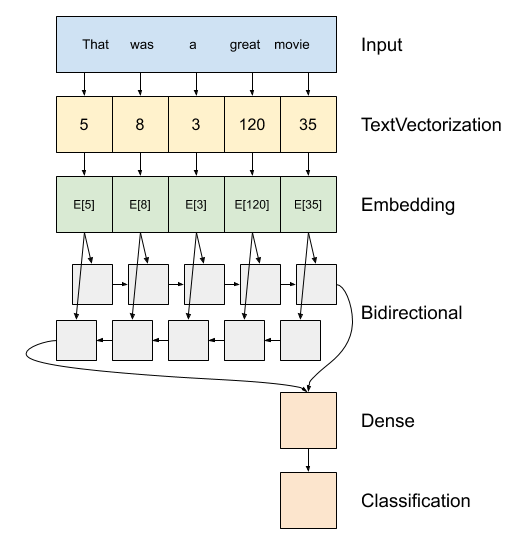

In [61]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])


In [76]:
model = tf.keras.Sequential()
model.add(encoder)
model.add(tf.keras.layers.Embedding(
                                     input_dim=len(encoder.get_vocabulary()),
                                     output_dim=64,
                                     # Use masking to handle the variable sequence lengths
                                     mask_zero=False
                                    )
          )

model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))

model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(1))


In [77]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])


In [ ]:
history = model.fit(train, epochs=10,
                    validation_data=test
                    )

Epoch 1/10
782/782 [==============================] - 700s 892ms/step - loss: 0.5664 - accuracy: 0.6416 - val_loss: 0.3488 - val_accuracy: 0.8503
Epoch 2/10
782/782 [==============================] - 696s 890ms/step - loss: 0.3051 - accuracy: 0.8734 - val_loss: 0.3074 - val_accuracy: 0.8748
Epoch 3/10
782/782 [==============================] - 718s 919ms/step - loss: 0.2526 - accuracy: 0.9004 - val_loss: 0.2933 - val_accuracy: 0.8772
Epoch 4/10
593/782 [=====================>........] - ETA: 2:24 - loss: 0.2232 - accuracy: 0.9122

In [34]:
history = model.fit(train, epochs=10)

Epoch 1/10


TypeError: ignored

### Labeling each example

In [ ]:
# tf.cast casts a tensor to a new datatype:
#  tf.int32, tf.int64, tf.float64 etc

tf.cast(1, tf.int64)
tf.cast(1.2, tf.float64)

<tf.Tensor: shape=(), dtype=float64, numpy=1.2000000476837158>

In [ ]:
# Define a labeler function:
#  example is a tf.data.Dataset
#    having many examples:
#     Label each one with 'index' after
#      it is cast to integer (tensorflow):

def labeler(example, index):
  return example, tf.cast(index, tf.int64)


#### An example

In [ ]:
# Create two tf.data.Datsets

d1 = tf.data.Dataset.from_tensor_slices([1,2,3,4])
d2 = tf.data.Dataset.from_tensor_slices([6,7,8,9])


In [ ]:
d1
d2

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>

In [ ]:
# Print one element at a time:

for i in d1.take(2):
  print(i)

tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)


In [ ]:
# Use as_numpy_iterator():
#  as_numpy_iterator() returns an iterator through which you can convert
#   all elements of the dataset to numpy.

list(d1.as_numpy_iterator())
print("\n======\n")
for i in d1.as_numpy_iterator():
  print(i)

[1, 2, 3, 4]



1
2
3
4


map() function:<br>
See [here](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) examples of map() usage<br>
`map()` transformation applies `map_func` to each element of this dataset, and returns a new dataset containing the transformed elements, in the same order as they appeared in the input. `map_func` can be used to change both the values **and the structure** of a dataset's elements.

In [ ]:
# Apply labeler function:

t = []
for i,j in enumerate([d1,d2]):
  t.append(j.map(lambda x: labeler(x,i)))

In [ ]:
# Examine each labeled Dataset:

for x in t:
  print(list(x.as_numpy_iterator()))
  print(type(x))

[(1, 0), (2, 0), (3, 0), (4, 0)]
<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
[(6, 1), (7, 1), (8, 1), (9, 1)]
<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>


In [ ]:
t = []
for j in [d1,d2]:
  t.append(j.map(lambda x: x+10))




In [ ]:
for j in t[0].as_numpy_iterator():
  print(j)

11
12
13
14


## Next, with our data

In [ ]:
FILE_NAMES = ['cowper.txt', 'derby.txt', 'butler.txt']

In [ ]:
labeled_data_sets = []

for i, file_name in enumerate(FILE_NAMES):
  lines_dataset = tf.data.TextLineDataset(str(data_path / file_name))
  labeled_dataset = lines_dataset.map(lambda ex: labeler(ex, i))
  labeled_data_sets.append(labeled_dataset)

In [ ]:
for text,label in labeled_data_sets[0].take(5):
  print(text)
  print(text.numpy())
  print(label)
  print(label.numpy())
  print("\n====\n")

tf.Tensor(b"\xef\xbb\xbfAchilles sing, O Goddess! Peleus' son;", shape=(), dtype=string)
b"\xef\xbb\xbfAchilles sing, O Goddess! Peleus' son;"
tf.Tensor(0, shape=(), dtype=int64)
0
tf.Tensor(b'His wrath pernicious, who ten thousand woes', shape=(), dtype=string)
b'His wrath pernicious, who ten thousand woes'
tf.Tensor(0, shape=(), dtype=int64)
0
tf.Tensor(b"Caused to Achaia's host, sent many a soul", shape=(), dtype=string)
b"Caused to Achaia's host, sent many a soul"
tf.Tensor(0, shape=(), dtype=int64)
0
tf.Tensor(b'Illustrious into Ades premature,', shape=(), dtype=string)
b'Illustrious into Ades premature,'
tf.Tensor(0, shape=(), dtype=int64)
0
tf.Tensor(b'And Heroes gave (so stood the will of Jove)', shape=(), dtype=string)
b'And Heroes gave (so stood the will of Jove)'
tf.Tensor(0, shape=(), dtype=int64)
0


## Prepare the dataset for training